In [2]:
# Importing the libraries
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import torch

In [3]:
transform=transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])
full_dataset = datasets.ImageFolder('/kaggle/input/dataset2/data_2', transform=transform)
print(len(full_dataset))

1200


In [4]:
test_size = int(0.2 * len(full_dataset))
train_size = len(full_dataset) - test_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [5]:
vgg16 = models.vgg16(pretrained=False)

num_features = vgg16.classifier[6].in_features
vgg16.classifier[6] = torch.nn.Linear(num_features, 20)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16 = vgg16.to(device)
device

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


device(type='cpu')

In [6]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

In [7]:
epochs = 10

for epoch in range(epochs):
    vgg16.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = vgg16(images)
        loss = criterion(outputs, labels)
        loss.backward()  #
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")

    # Test loop
    vgg16.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = vgg16(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Test Loss: {test_loss/len(test_loader)}, Accuracy: {100 * correct / total}%')

Epoch 1/10, Loss: 2.9985935211181642
Test Loss: 2.997782737016678, Accuracy: 4.166666666666667%
Epoch 2/10, Loss: 2.9833887894948323
Test Loss: 2.999624252319336, Accuracy: 3.75%
Epoch 3/10, Loss: 2.9845545212427775
Test Loss: 2.9937630593776703, Accuracy: 4.583333333333333%
Epoch 4/10, Loss: 2.9702700694402058
Test Loss: 2.9841048419475555, Accuracy: 5.416666666666667%
Epoch 5/10, Loss: 2.9602049509684245
Test Loss: 2.964599162340164, Accuracy: 10.416666666666666%
Epoch 6/10, Loss: 2.9085492213567097
Test Loss: 2.911234498023987, Accuracy: 10.0%
Epoch 7/10, Loss: 2.8240488529205323
Test Loss: 2.831893414258957, Accuracy: 11.25%
Epoch 8/10, Loss: 2.7546581745147707
Test Loss: 2.761796772480011, Accuracy: 17.5%
Epoch 9/10, Loss: 2.6706042210261027
Test Loss: 2.7404740154743195, Accuracy: 17.916666666666668%
Epoch 10/10, Loss: 2.710040060679118
Test Loss: 2.7219560146331787, Accuracy: 19.166666666666668%


**Analysis of Result**

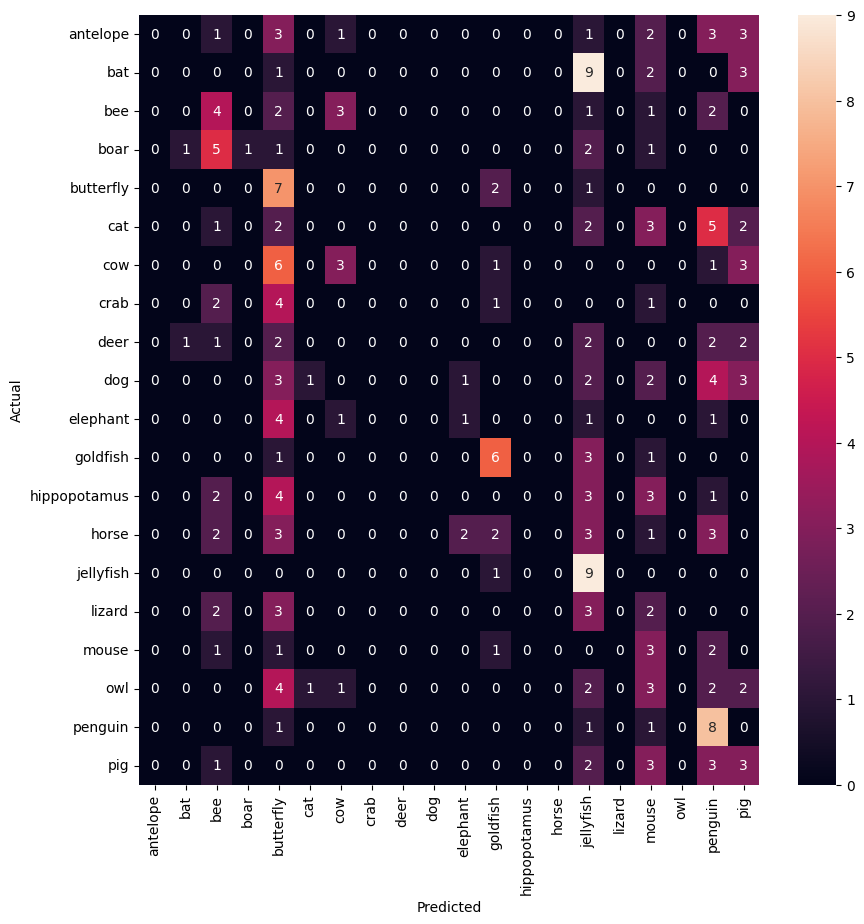

In [8]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, preds = torch.max(outputs, 1)
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,labels.view(-1).cpu()])

conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=test_dataset.dataset.classes,
            yticklabels=test_dataset.dataset.classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [9]:
import numpy as np
from sklearn.metrics import classification_report

all_preds = []
all_labels = []

vgg16.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.view(-1).cpu().numpy())
        all_labels.extend(labels.view(-1).cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

class_report = classification_report(all_labels, all_preds, target_names=full_dataset.classes)

print(class_report)

              precision    recall  f1-score   support

    antelope       0.00      0.00      0.00        14
         bat       0.00      0.00      0.00        15
         bee       0.19      0.31      0.24        13
        boar       1.00      0.09      0.17        11
   butterfly       0.14      0.80      0.24        10
         cat       0.00      0.00      0.00        15
         cow       0.27      0.21      0.24        14
        crab       0.00      0.00      0.00         8
        deer       0.00      0.00      0.00        10
         dog       0.00      0.00      0.00        16
    elephant       0.25      0.12      0.17         8
    goldfish       0.50      0.55      0.52        11
hippopotamus       0.00      0.00      0.00        13
       horse       0.00      0.00      0.00        16
   jellyfish       0.20      0.90      0.32        10
      lizard       0.00      0.00      0.00        10
       mouse       0.08      0.25      0.12         8
         owl       0.00    

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
